In [1]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

## Download the data


In [2]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 137MB/s]


In [34]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 48.4 MB/s eta 0:00:00


In [3]:
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
HIDDEN_DIM = 256  # Latent dimensionality of the encoding space.
EMBEDDING_DIM = 64
NUM_SAMPLES = 33000  # Number of samples to train on.

In [4]:
import pandas as pd

df = pd.read_excel('/content/1_구어체(1).xlsx')
df

,SID,원문,번역문
0,1,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2,씨티은행에서 일하세요?,Do you work at a City bank?
2,3,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
199996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
199997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
199998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


## 데이터 전처리

In [35]:
def preprocess_sentence(sent):
    # 단어와 구두점 사이의 공백
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # 한글 / 특정 기호 제외하고는 제거
    sent = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ!.?]", r" ", sent)

    # 다수의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent

In [36]:
kor_corpus = df['원문'].to_list()
eng_corpus = df['번역문'].to_list()

print(len(kor_corpus), kor_corpus[:10])
print(len(eng_corpus), eng_corpus[:10])

200000 ["'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱입니다.", '씨티은행에서 일하세요?', '푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.', '11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.', '6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.', 'F/W 겐조타이거 키즈와 그리고 이번에 주문한 키즈 중 부족한 수량에 대한 환불입니다.', '강아지들과 내 사진을 보낼게.', '그 수익금 중 일부를 위안부 할머니들을 위해 쓰고 그들을 위해 여러 가지 캠페인을 벌이고 있습니다.', '그들은 내가 잘하는 것을 바탕으로 별명을 사용하고 있기 때문에 나는 사람들이 치타라고 불러주면 기분이 좋아.', '그러므로 실제로 컴퓨터 프로그램을 만든 사람이 프로그램에 대한 저작자가 돼요.']
200000 ["Bible Coloring' is a coloring application that allows you to experience beautiful stories in the Bible.", 'Do you work at a City bank?', "PURITO's bestseller, which recorded 4th rough -cuts by words of mouth from abroad.", 'In Chapter 11 Jesus called Lazarus from the tomb and raised him from the dead.', 'I would feel grateful to know how many stocks will be secured of size 6.5, 7, and 8.', '18fw Kenzo Tiger Kids, and refund for lacking quantity of Kids which was ordered this time.', "And I'll send you a picture of me and 

In [ ]:
from konlpy.tag import Okt
okt = Okt()
tmp = []
for i in kor_corpus:
    tmp.append(okt.morphs(i))
tmp

In [41]:
tmp_final = []
for i in tmp:
    tmp_final.append(' '.join(i))
tmp_final

["' Bible Coloring ' 은 성경 의 아름다운 이야기 를 체험 할 수 있는 컬러링 앱 입니다 .",
 '씨티 은행 에서 일 하세요 ?',
 '푸리 토의 베스트셀러 는 해외 에서 입 소문 만으로 4 차 완판 을 기록 하였다 .',
 '11 장 에서는 예수님 이 이번 엔 나사 로 를 무덤 에서 불러내어 죽은 자 가운데 서 살리셨습니다 .',
 '6.5 , 7 , 8 사이즈 가 몇 개 나 더 재 입고 될지 제 게 알려주시면 감사하겠습니다 .',
 'F / W 겐조 타이거 키즈 와 그리고 이번 에 주문 한 키즈 중 부족한 수량 에 대한 환불 입니다 .',
 '강아지 들 과 내 사진 을 보낼게 .',
 '그 수익금 중 일부 를 위안부 할머니 들 을 위해 쓰고 그 들 을 위해 여러 가지 캠페인 을 벌이 고 있습니다 .',
 '그 들 은 내 가 잘 하는 것 을 바탕 으로 별명 을 사용 하고 있기 때문 에 나 는 사람 들 이 치타 라고 불러주면 기분 이 좋아 .',
 '그러므로 실제 로 컴퓨터 프로그램 을 만든 사람 이 프로그램 에 대한 저작자 가 돼요 .',
 '나 는 친구 에게 그 철학자 의 책 을 선물 해 주겠다고 말 했습니다 .',
 '나머지 사진 은 내 친구 들 이야 .',
 '나머지 시간 에는 공부 해요 .',
 '네 가 하는 일과 공부 잘 하길 멀리 서 응원 할게 .',
 '다른 선수 들 이 몬스터 를 사냥 할 경우 당신 은 추가 경험치 를 획득 해요 .',
 '당신 에게 영화관 티켓 을 그냥 보여 주면 되나요 ?',
 '마치 목욕탕 창구 처럼 보일 까말까 한 작은 구멍 으로 내 가 돈 을 주면 그 여자 가 교통카드 를 충전 시켜주었던 기억 이 납니다 .',
 '문화 뿐 만 아니라 그 나라 만의 독특한 사회 전체 의 유기 적 관계 를 알 수 있습니다 .',
 '얼마 전 가진 A 사 와의 회의 결과 , 본계약 의 계약 시점 은 약간 지연 된다고 합니다 .',
 '에어비앤비 투어 서비스 를 운영자 의 프로필 사진 을 촬영 하고 이야기 를 정리 해 사이트

In [39]:
def load_preprocessed_data(eng_corpus, kor_corpus):
    encoder_input, decoder_input, decoder_target = [], [], []

    for i, (src_line, tar_line) in enumerate(zip(kor_corpus, eng_corpus)):
        # source 데이터 전처리
        src_line = [w for w in preprocess_sentence(src_line).split()]

        # target 데이터 전처리
        tar_line = preprocess_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋 
        tar_line_out = [w for w in (tar_line + " <eos>").split()]

        encoder_input.append(src_line) # 클리닝 
        decoder_input.append(tar_line_in) # 클리닝 + sos 
        decoder_target.append(tar_line_out) # 클리닝 + eos 

        if i == NUM_SAMPLES - 1:
            break
                    
    return encoder_input, decoder_input, decoder_target

In [42]:
sents_kor_in, sents_en_in, sents_en_out  = load_preprocessed_data(eng_corpus, tmp_final)

In [ ]:
kor_corpus = tmp_final

In [44]:
print('인코더의 입력 :',sents_kor_in[-5:]) # encoder input o, target x
print('디코더의 입력 :',sents_en_in[-5:])
print('디코더의 레이블 :',sents_en_out[-5:])

인코더의 입력 : [['그래서', '그녀', '의', '엄마', '가', '그녀', '는', '외우는', '것', '을', '하지', '않기를', '원해요', '.'], ['그래서', '그', '는', '그', '의', '미팅', '에서', '집단지성', '을', '사용', '해요', '.'], ['그래서', '그', '는', '근대', '의', '산물', '중', '가장', '보편', '적', '이라고', '할', '수', '있는', '콘크리트', '를', '주로', '사용', '했습니다', '.'], ['그래서', '그', '는', '내', '인생', '의', '최고', '의', '예술가', '입니다', '.'], ['그래서', '그', '는', '노래방', '에', '갈', '때', '마다', '그걸', '불러', '.']]
디코더의 입력 : [['<sos>', 'So', 'her', 'mother', 'wants', 'her', 'not', 'to', 'memorize', '.'], ['<sos>', 'So', 'they', 're', 'using', 'group', 'intelligence', 'in', 'his', 'meetings', '.'], ['<sos>', 'So', 'he', 'usually', 'used', 'concrete', 'which', 'is', 'the', 'most', 'universal', 'modern', 'product', '.'], ['<sos>', 'So', 'to', 'me', 'he', 's', 'the', 'best', 'artist', 'of', 'all', 'time', '.'], ['<sos>', 'So', 'he', 'sings', 'it', 'each', 'time', 'he', 'goes', 'to', 'karaoke', '.']]
디코더의 레이블 : [['So', 'her', 'mother', 'wants', 'her', 'not', 'to', 'memorize', '.', '<eos>'], ['So

- 단어집합 생성

In [45]:
# 한글 (encoder)

# vocab dict 생성
tokenizer_enc = Tokenizer(filters = "", lower = False) # filters : 걸러낼 문자 리스트 / lower : 입력받은 문자열을 소문자로 변환할지
tokenizer_enc.fit_on_texts(sents_kor_in) 

# 인코더 생성(단어 인덱싱)
encoder_input = tokenizer_enc.texts_to_sequences(sents_kor_in) # encoder 입력값

In [46]:
# 영어 (decoder)

# vocab dict 생성
tokenizer_dec = Tokenizer(filters = "", lower = False)
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)

# 디코더 생성(단어 인덱싱) - input / output 둘 다 존재
decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)

- 단어 집합 크기 정의

In [47]:
print(tokenizer_enc.word_index)
print(tokenizer_dec.word_index)

{'.': 1, '을': 2, '그': 3, '는': 4, '에': 5, '이': 6, '은': 7, '의': 8, '를': 9, '가': 10, '들': 11, '그녀': 12, '것': 13, '?': 14, '에서': 15, '으로': 16, '입니다': 17, '수': 18, '로': 19, '한': 20, '할': 21, '있습니다': 22, '그것': 23, '합니다': 24, '과': 25, '하는': 26, '일': 27, '적': 28, '해': 29, '하고': 30, '와': 31, '에게': 32, '사람': 33, '이에요': 34, '도': 35, '나': 36, '요': 37, '했어요': 38, '인': 39, '월': 40, '고': 41, '년': 42, '우리': 43, '있는': 44, '했습니다': 45, '말': 46, '당신': 47, '때': 48, '내': 49, '때문': 50, '곳': 51, '있어요': 52, '생각': 53, '에는': 54, '잘': 55, '제품': 56, '저': 57, '시간': 58, '하지': 59, '까지': 60, '못': 61, '더': 62, '고객': 63, '제': 64, '후': 65, '가장': 66, '된': 67, '위해': 68, '사용': 69, '중': 70, '해요': 71, '거': 72, '안': 73, '가지': 74, '만': 75, '하여': 76, '시': 77, '한국': 78, '서': 79, '친구': 80, '대해': 81, '확인': 82, 'A': 83, '많은': 84, '개': 85, '전': 86, '해서': 87, '됩니다': 88, '많이': 89, '다': 90, '게': 91, '있어': 92, '예요': 93, '대한': 94, '위': 95, '번': 96, '진행': 97, '다른': 98, '문제': 99, '부터': 100, '하기': 101, '되었습니다': 102, '알': 103, '가격': 104, '가족'

In [48]:
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE = len(tokenizer_dec.word_index) + 1

print(f"영어 단어 집합의 크기 : {TAR_VOCAB_SIZE}, 한글 단어 집합의 크기 : {SRC_VOCAB_SIZE}")

영어 단어 집합의 크기 : 20507, 한글 단어 집합의 크기 : 30597


- 패딩(Padding)

In [49]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [50]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1]
MAX_ENC_LEN, MAX_DEC_LEN

인코더의 입력의 크기(shape) : (33000, 35)
디코더의 입력의 크기(shape) : (33000, 44)
디코더의 레이블의 크기(shape) : (33000, 44)


(35, 44)

- 단어to정수 / 정수to단어 : 예측값과 실제값을 비교하기 위함

In [51]:
src2idx = tokenizer_enc.word_index  # word : idx
idx2src = tokenizer_enc.index_word  # idx : word
tar2idx = tokenizer_dec.word_index # word : idx
idx2tar = tokenizer_dec.index_word # idx : word

- 시퀀스 랜덤하게 섞기 (feat. 이런 방법도 있다는 것 알아두기)
    - `<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스 

In [52]:
# 랜덤 인덱스 생성 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

# 랜덤하게 섞기 - 랜덤하게 섞이지만 3개의 dataset이 동일하게 섞임
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print()
print(decoder_input[indices[0]])
print(decoder_target[indices[0]])

랜덤 시퀀스 : [27824 30213  4706 ...  6844 21355  1477]

[   3   22 7183   33   30   10  274   30    5  162   41   11    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[  22 7183   33   30   10  274   30    5  162   41   11    1    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


- test 데이터 분리

In [53]:
n_of_train = int(NUM_SAMPLES*0.9)

# train data
encoder_input_train = encoder_input[:n_of_train] 
decoder_input_train = decoder_input[:n_of_train]
decoder_target_train = decoder_target[:n_of_train]

# test data
encoder_input_test = encoder_input[n_of_train:]
decoder_input_test = decoder_input[n_of_train:]
decoder_target_test = decoder_target[n_of_train:]

In [54]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 35)
훈련 target 데이터의 크기 : (29700, 44)
훈련 target 레이블의 크기 : (29700, 44)
테스트 source 데이터의 크기 : (3300, 35)
테스트 target 데이터의 크기 : (3300, 44)
테스트 target 레이블의 크기 : (3300, 44)


## Modeling


- 인코더

In [55]:
# 인코더 (Train)

## 층 
enc_emb_layer = Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM)
encoder_lstm = LSTM(HIDDEN_DIM, return_state = True) # 상태값 리턴을 위해 return_state는 True


## input -> output 
encoder_inputs = Input(shape=(None, )) # 입력
enc_emb = enc_emb_layer(encoder_inputs) # 단어 임베딩
encoder_outputs, state_h, state_c =  encoder_lstm(enc_emb) # LSTM

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 리스트로 저장 (encoder의 output --> context vector)

- 디코더

In [56]:
# 디코더 (Train)
decoder_inputs = Input(shape=(None, ))

## 층
#상태값 리턴을 위해 lstm layer return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, HIDDEN_DIM)
decoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True, return_state = True) 
decoder_dense = Dense(TAR_VOCAB_SIZE, activation = 'softmax')


## input -> output 
# 인코더 RNN의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states) # initial_state = encoder_states : 글자(hidden state) 생성

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_outputs = decoder_dense(decoder_outputs)

In [57]:
# 모델의 입력과 출력을 정의.
# seq2seq
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [58]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     1958208     ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 256)    5249792     ['input_6[0][0]']                
                                                                                            

In [59]:
# callbacks : earlystopping, checkpoint (중요) // tensorboard
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

history = model.fit(x = [encoder_input_train, decoder_input_train], 
          y = decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = BATCH_SIZE, 
          callbacks = [earlystopping],
          epochs = 100)

Epoch 1/100
465/465 [==============================] - 75s 152ms/step - loss: 2.1014 - acc: 0.7399 - val_loss: 1.6834 - val_acc: 0.7628
Epoch 2/100
465/465 [==============================] - 40s 85ms/step - loss: 1.5964 - acc: 0.7699 - val_loss: 1.5569 - val_acc: 0.7737
Epoch 3/100
465/465 [==============================] - 41s 87ms/step - loss: 1.4807 - acc: 0.7793 - val_loss: 1.4969 - val_acc: 0.7800
Epoch 4/100
465/465 [==============================] - 38s 81ms/step - loss: 1.4102 - acc: 0.7851 - val_loss: 1.4670 - val_acc: 0.7817
Epoch 5/100
465/465 [==============================] - 37s 80ms/step - loss: 1.3505 - acc: 0.7907 - val_loss: 1.4397 - val_acc: 0.7865
Epoch 6/100
465/465 [==============================] - 38s 83ms/step - loss: 1.2950 - acc: 0.7948 - val_loss: 1.4275 - val_acc: 0.7879
Epoch 7/100
465/465 [==============================] - 38s 83ms/step - loss: 1.2472 - acc: 0.7980 - val_loss: 1.4166 - val_acc: 0.7891
Epoch 8/100
465/465 [==============================] -

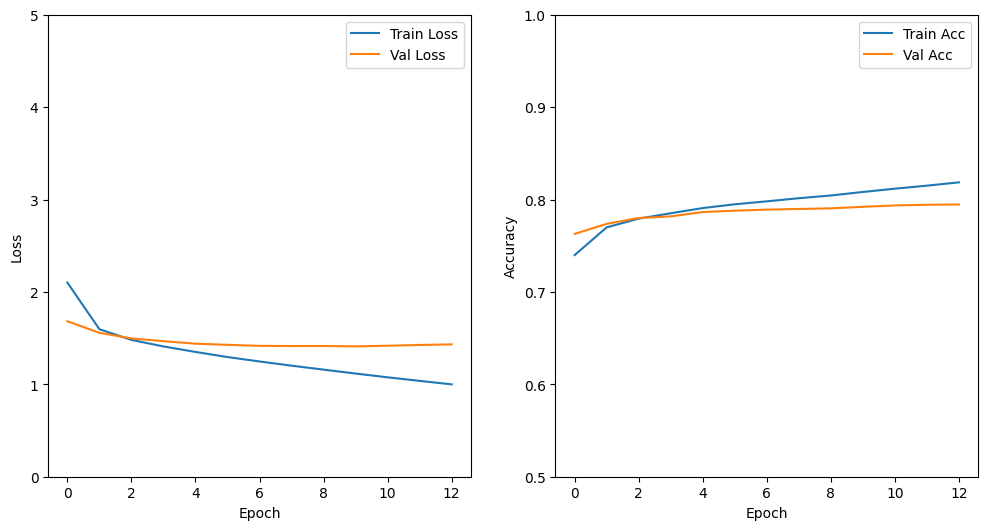

In [60]:
import matplotlib
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(12, 6))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Acc')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Acc')
  plt.ylim([0.5,1])
  plt.legend()
  plt.show()

plot_history(history)

## Inference

- 인코더 : 입력 2개 (hidden state, cell state)
- 디코더 : 입력 3개 (embedding, hidden state, cell state)

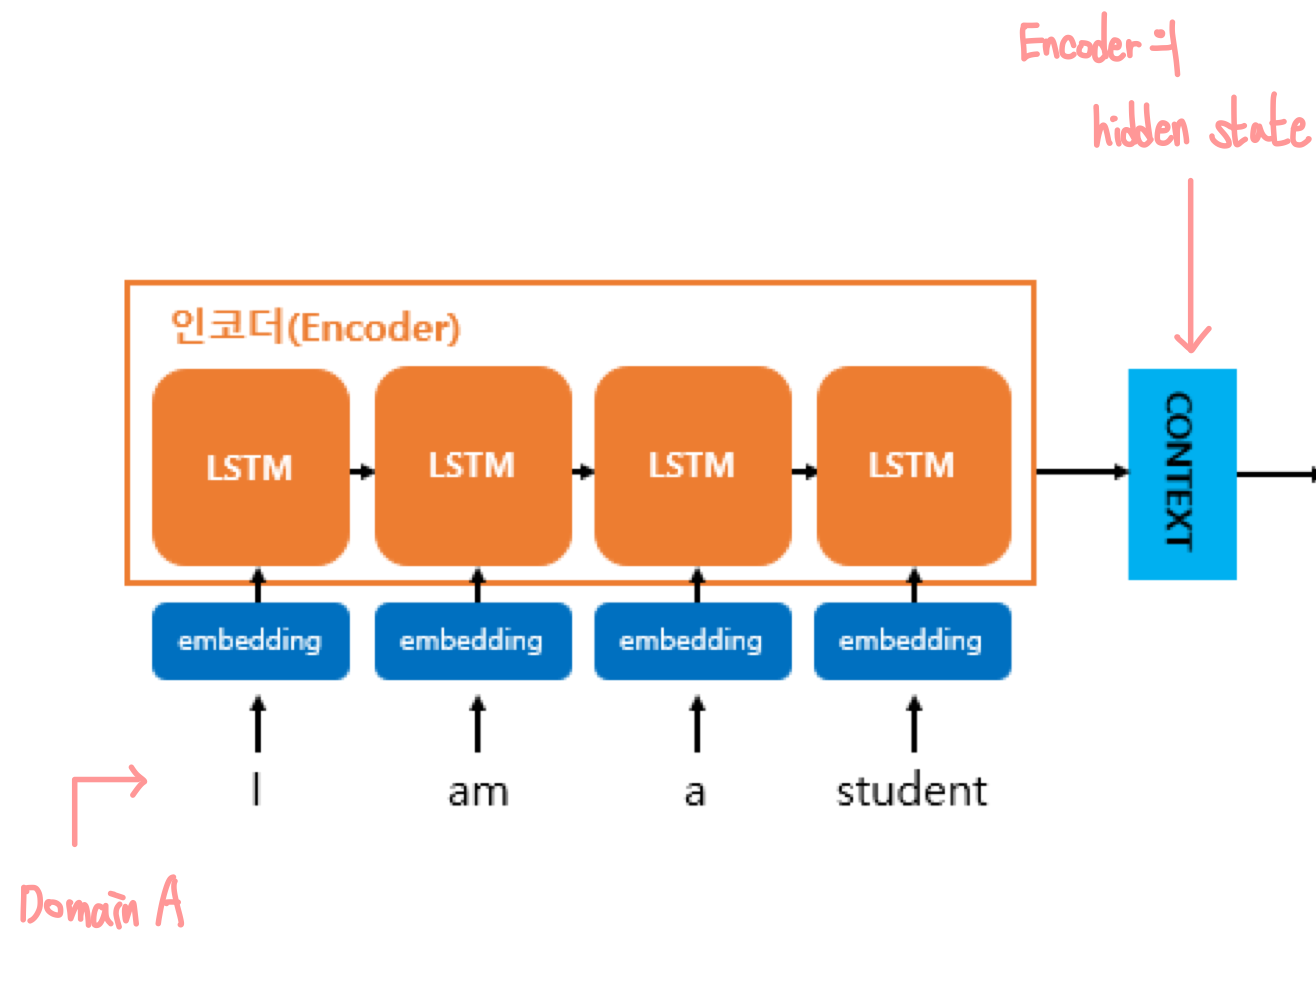

In [61]:
# 인코더 - 훈련과 동일
encoder_model = Model(encoder_inputs, encoder_states)

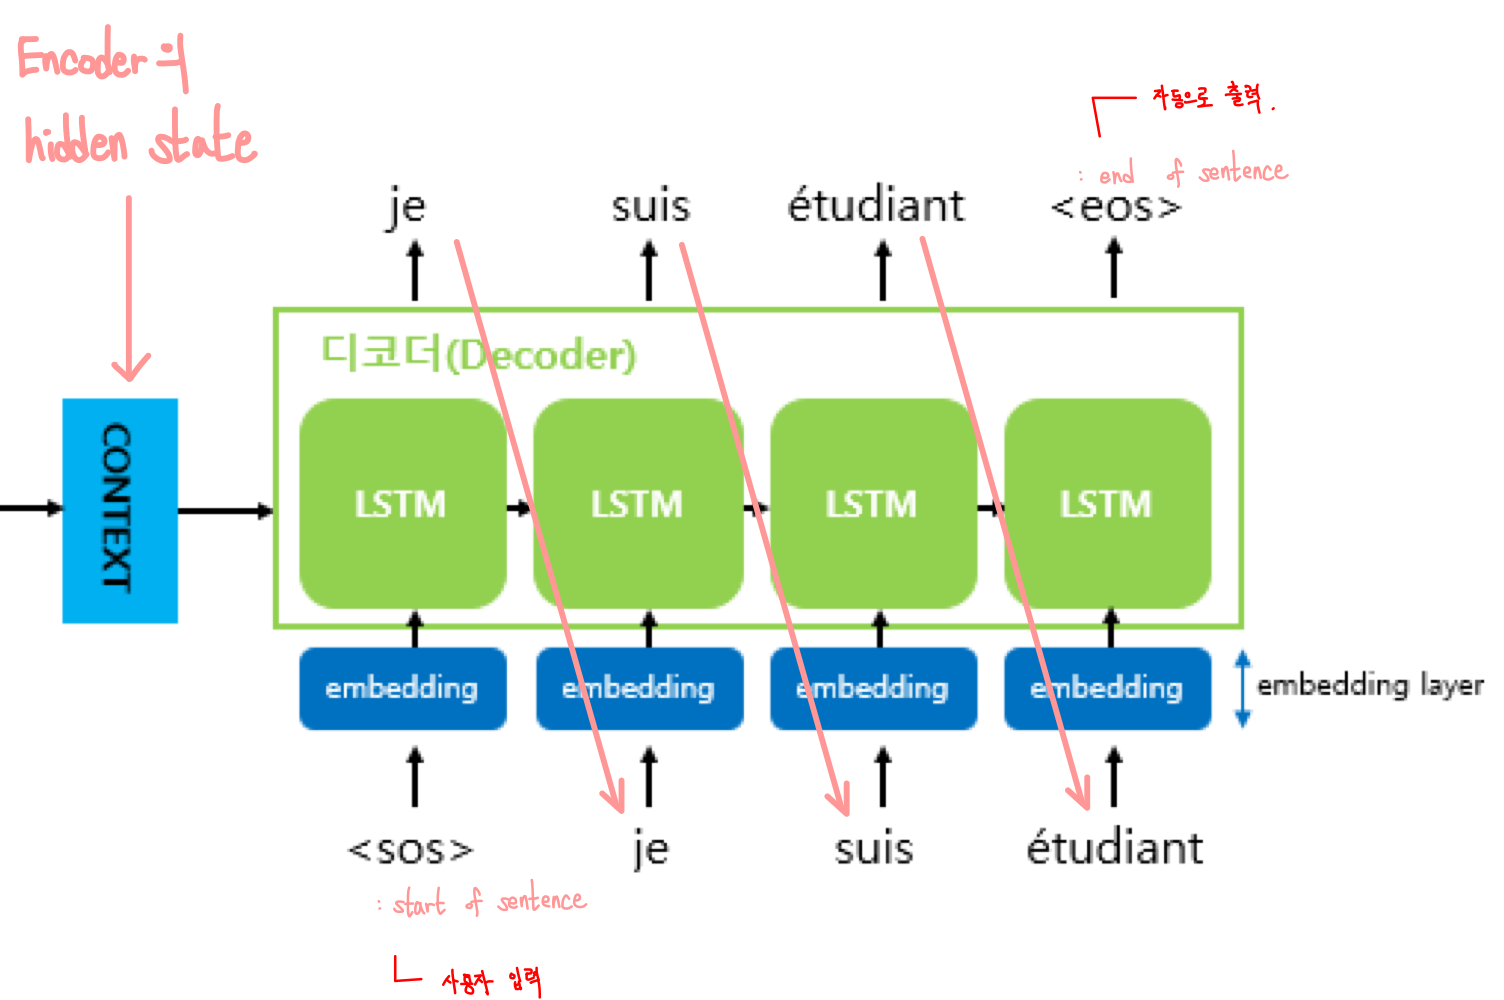

In [62]:
# 디코더 (Predict)

# Input Tensors : 이전 시점의 상태를 보관할 텐서
decoder_input_h = Input(shape=(HIDDEN_DIM,))
decoder_input_c = Input(shape=(HIDDEN_DIM,))

decoder_states_inputs = [decoder_input_h, decoder_input_c] # input context vector

# 훈련 때 사용했던 임베딩 층을 재사용
x = dec_emb_layer(decoder_inputs) # input word - 처음: <sos> / 다음에는 이전 cell의 출력

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h2, state_c2 = decoder_lstm(x, initial_state=decoder_states_inputs) # hidden, cell --> lstm output
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측 (Fully Connected)
x = decoder_dense(x)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [x] + decoder_states2) # [x, state_h2, state_c2]

- 테스트 단계 동작 함수

In [63]:
def translate(sentence):
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    # 입력 문장 토큰 -> 라벨링
    enc_input = tokenizer_enc.texts_to_sequences([tokens]) # ex : [23, 56,2]

    # 입력 문장 라벨링 -> 패딩 
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post') # ex : [23, 56, 2, ..., 0, 0, 0]
    
    # Encoder
    states_value = encoder_model.predict(enc_input) # context vector

    # Decoder input인 <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar2idx['<sos>']


    # prediction 시작
    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    stop_condition = False
    decoded_sentence = ''

    for t in range(MAX_DEC_LEN):

        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)

        # 예측 결과를 단어로 변환
        result_token_index = np.argmax(output_tokens[0, -1, :])
        result_word = idx2tar[result_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+result_word

        # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = result_token_index

        # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
        states_value = [h, c]

        #  Stop condition <eos>에 도달하면 중단.
        if result_word == '<eos>':
            break 

    return decoded_sentence.strip(' <eos>')

- 결과 확인

In [64]:
train_idx = indices[:n_of_train]
test_idx = indices[n_of_train:] 

In [65]:
n_samples = 5
np.random.choice(train_idx, n_samples)

array([25796, 14338,  5275, 18054, 19391])

In [66]:
# train data - translate
n_samples = 5
for idx in np.random.choice(train_idx, n_samples):
    test_sentence = kor_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence) 
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 357ms/step
입력문장 : 그 는 어렸을 때 부터 매우 열심히 살았어 .
정답문장 : He's been living his life to the fullest since he was a child.
번역문장 : He is a very famous singer in the world .
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : 그 들 중 에 한 명 은 신문 인턴 기자 였어요 .
정답문장 : One of them was an intern newspaper reporter.
번역문장 : I think that it is a lot of the most important thing in the movie .
--------------------------------------------------
1/1 [==============================] - 0s 29ms/step
입력문장 : 거기 보증 서는 들어있습니까 ?
정답문장 : Is there a warranty?
번역문장 : How much is the most ?
--------------------------------------------------
1/1 [==============================] - 0s 27ms/step
입력문장 : 그것 을 당신 이 말 하는 방법 대로 이 곳 에 보내는 것 이 불법 적 입니다 .
정답문장 : The way to send the money as you said to me is illegal.
번역문장 : I will be a good time to get a good time to get a good time .
--------------------------------------------------
1/1

In [67]:
# test data - translate
n_samples = 5
for idx in np.random.choice(test_idx, n_samples):
    test_sentence = kor_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence) 
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 24ms/step
입력문장 : 그 는 지난주 에 서울 에 도착 했습니다 .
정답문장 : He arrived in Seoul last week.
번역문장 : He is a very famous singer in the world .
--------------------------------------------------
1/1 [==============================] - 0s 26ms/step
입력문장 : 그 들 의 사업 의지 가 매우 강합니다 .
정답문장 : Their will for the business is very strong.
번역문장 : I think that it is a lot of the most beautiful .
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : SNS 기반 으로 한 셀러브리티 들 의 인기 가 상승 했습니다 .
정답문장 : Celebrities and their fame have gone up with SNS usage.
번역문장 : We are going to get a refund for the airport to the airport .
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : 그것 은 끝 을 마무리 하는 것 을 암시 해요 .
정답문장 : It implies to end up.
번역문장 : It s because of the movie is a good person .
--------------------------------------------------
1/1 [==============================] - 